#Try Again

In [ ]:
!pip install numpy pandas scikit-learn matplotlib optuna haversine

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import optuna
from haversine import haversine
import random

In [ ]:
# Sample input (replace with your actual input)
sites = [
    ("Site A", 2.3522, 48.8566, True, 3),
    ("Site B", 2.3488, 48.8530, False, 2),
    ("Site C", 2.3376, 48.8606, True, 4),
    ("Site D", 2.2950, 48.8738, False, 3),
    ("Site E", 2.3708, 48.8450, True, 2),
    ("Site F", 2.2840, 48.8607, False, 3),
    ("Site G", 2.3310, 48.8685, True, 3),
    ("Site H", 2.3520, 48.8500, True, 2),
    ("Site I", 2.3150, 48.8550, False, 4),
    ("Site J", 2.3580, 48.8620, True, 2),
    ("Site K", 2.3421, 48.8473, True, 5),
    ("Site L", 2.3275, 48.8512, False, 1),
    ("Site M", 2.3667, 48.8578, True, 4),
    ("Site N", 2.3019, 48.8495, False, 2),
    ("Site O", 2.3544, 48.8639, True, 3),
    ("Site P", 2.2891, 48.8542, True, 3),
    ("Site Q", 2.3723, 48.8486, False, 4),
    ("Site R", 2.3358, 48.8591, True, 2),
    ("Site S", 2.3217, 48.8644, False, 1),
    ("Site T", 2.3476, 48.8667, True, 5),
    ("Site U", 2.3033, 48.8583, True, 3),
    ("Site V", 2.3642, 48.8521, False, 2),
    ("Site W", 2.3389, 48.8458, True, 4),
    ("Site X", 2.3125, 48.8672, True, 3),
    ("Site Y", 2.3567, 48.8494, False, 2),
    ("Site Z", 2.3248, 48.8536, True, 5),
    ("Site AA", 2.2987, 48.8625, False, 1),
    ("Site AB", 2.3678, 48.8556, True, 3),
    ("Site AC", 2.3415, 48.8689, True, 4),
    ("Site AD", 2.3192, 48.8517, False, 2),
    ("Site AE", 2.3529, 48.8472, True, 3),
    ("Site AF", 2.3324, 48.8643, False, 5),
    ("Site AG", 2.3066, 48.8564, True, 2),
    ("Site AH", 2.3583, 48.8597, True, 4),
    ("Site AI", 2.3451, 48.8548, False, 1),
    ("Site AJ", 2.3279, 48.8573, True, 3),
    ("Site AK", 2.3741, 48.8465, True, 5),
    ("Site AL", 2.3025, 48.8658, False, 2),
    ("Site AM", 2.3367, 48.8519, True, 4),
    ("Site AN", 2.3555, 48.8612, True, 3),
]

n_days = 10
max_hours = 24

In [ ]:
df["hours_norm"] = df["hours_needed"] / df["hours_needed"].max()

# Feasibility check
total_hours = df["hours_needed"].sum()
max_total_capacity = n_days * max_hours

if total_hours > max_total_capacity:
    raise ValueError(f"❌ Infeasible: You need {total_hours} hours, but only {max_total_capacity} hours available with {n_days} days × {max_hours} hours/day.")

In [ ]:
# Objective function for Optuna
def objective(trial):
    weight_hours = trial.suggest_float("weight_hours", 0.0, 1.0)
    kmeans = KMeans(n_clusters=n_days, random_state=42)

    # Weighted coordinates: (lon, lat, weight_hours * hours_needed)
    X = df[["lon", "lat"]].values
    X_weighted = np.hstack([X, df[["hours_norm"]].values * weight_hours])

    clusters = kmeans.fit_predict(X_weighted)
    df["cluster"] = clusters

    penalty = 0
    for i in range(n_days):
        day_hours = df[df["cluster"] == i]["hours_needed"].sum()
        penalty += abs(day_hours - max_hours)  # penalize deviation from max_hours
        if day_hours > max_hours:
            penalty += (day_hours - max_hours) * 10  # harsh penalty for overflow

    # Also penalize stddev across day hours (we want balance)
    day_totals = [df[df["cluster"] == i]["hours_needed"].sum() for i in range(n_days)]
    penalty += np.std(day_totals) * 5

    return penalty

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-08-03 21:17:22,134] A new study created in memory with name: no-name-623f3be6-bf85-460c-8287-bd79a9b6c788
[I 2025-08-03 21:17:22,151] Trial 0 finished with value: 165.20636583037583 and parameters: {'weight_hours': 0.9357731348801464}. Best is trial 0 with value: 165.20636583037583.
[I 2025-08-03 21:17:22,167] Trial 1 finished with value: 165.20636583037583 and parameters: {'weight_hours': 0.9775402740725546}. Best is trial 0 with value: 165.20636583037583.
[I 2025-08-03 21:17:22,182] Trial 2 finished with value: 165.20636583037583 and parameters: {'weight_hours': 0.28651305735463506}. Best is trial 0 with value: 165.20636583037583.
[I 2025-08-03 21:17:22,199] Trial 3 finished with value: 144.17865397299852 and parameters: {'weight_hours': 0.05974474755622117}. Best is trial 3 with value: 144.17865397299852.
[I 2025-08-03 21:17:22,222] Trial 4 finished with value: 165.20636583037583 and parameters: {'weight_hours': 0.5080566914134638}. Best is trial 3 with value: 144.1786539729

In [ ]:
# Best clustering
best_weight = study.best_params["weight_hours"]
X = df[["lon", "lat"]].values
X_weighted = np.hstack([X, df[["hours_norm"]].values * best_weight])
kmeans = KMeans(n_clusters=n_days, random_state=42)
df["cluster"] = kmeans.fit_predict(X_weighted)

# Assign each cluster to a day
cluster_to_day = {c: f"Day {i+1}" for i, c in enumerate(sorted(df["cluster"].unique()))}
df["day"] = df["cluster"].map(cluster_to_day)

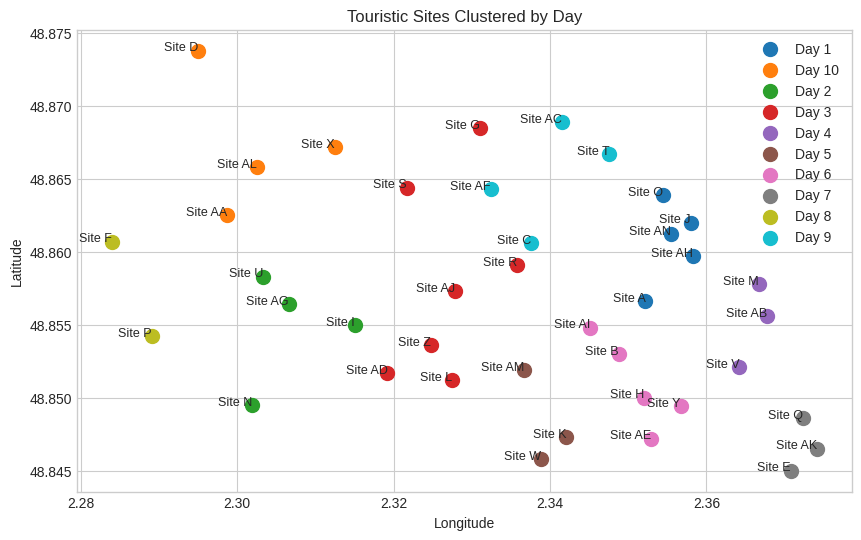


🗓️ Day 1 - Total Hours: 15h
  - Site A (3h, Outdoor)
  - Site J (2h, Outdoor)
  - Site O (3h, Outdoor)
  - Site AH (4h, Outdoor)
  - Site AN (3h, Outdoor)

🗓️ Day 10 - Total Hours: 9h
  - Site D (3h, Indoor)
  - Site X (3h, Outdoor)
  - Site AA (1h, Indoor)
  - Site AL (2h, Indoor)

🗓️ Day 2 - Total Hours: 11h
  - Site I (4h, Indoor)
  - Site N (2h, Indoor)
  - Site U (3h, Outdoor)
  - Site AG (2h, Outdoor)

🗓️ Day 3 - Total Hours: 17h
  - Site G (3h, Outdoor)
  - Site L (1h, Indoor)
  - Site R (2h, Outdoor)
  - Site S (1h, Indoor)
  - Site Z (5h, Outdoor)
  - Site AD (2h, Indoor)
  - Site AJ (3h, Outdoor)

🗓️ Day 4 - Total Hours: 9h
  - Site M (4h, Outdoor)
  - Site V (2h, Indoor)
  - Site AB (3h, Outdoor)

🗓️ Day 5 - Total Hours: 13h
  - Site K (5h, Outdoor)
  - Site W (4h, Outdoor)
  - Site AM (4h, Outdoor)

🗓️ Day 6 - Total Hours: 10h
  - Site B (2h, Indoor)
  - Site H (2h, Outdoor)
  - Site Y (2h, Indoor)
  - Site AE (3h, Outdoor)
  - Site AI (1h, Indoor)

🗓️ Day 7 - Total Hours:

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
for day, group in df.groupby("day"):
    plt.scatter(group["lon"], group["lat"], label=day, s=100)

for i, row in df.iterrows():
    plt.text(row["lon"], row["lat"], row["name"], fontsize=9, ha='right')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Touristic Sites Clustered by Day")
plt.legend()
plt.grid(True)
plt.show()

# Print final itinerary
for day, group in df.groupby("day"):
    print(f"\n🗓️ {day} - Total Hours: {group['hours_needed'].sum()}h")
    for _, row in group.iterrows():
        print(f"  - {row['name']} ({row['hours_needed']}h, {'Outdoor' if row['outdoor'] else 'Indoor'})")
